In [1]:
import gzip
from io import StringIO
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import re
import string
import json
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import matutils

/tmp/ipykernel_402343/834613930.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def gzip_file_to_documents_list(file_name, languages_filter=['en']):
    with gzip.open(file_name, 'rb') as f:
        decompressed_data = f.read()
    df_data = pd.read_csv(StringIO(str(decompressed_data,'utf-8')), index_col=0)
    documents = df_data[df_data['language'].isin(languages_filter)]['text'].tolist()
    return documents

In [3]:
def uctd_file_name_by_date(month, day):
    return '0'*int(month < 10) + str(month) + '0'*int(day < 10) + str(day) + "_UkraineCombinedTweetsDeduped.csv.gzip"

In [4]:
def get_uctd_documents_between_dates(start: str, end: str,
                                     languages_filter=['en'], verbose: int = 0):
    # Dates in the 'YYYY-DD-MM' format
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')
    delta_days = date_end - date_start
    all_documents = []
    for i_d in range(delta_days.days + 1):
        date_current = date_start + timedelta(days=i_d)
        uctd_file_name = uctd_file_name_by_date(date_current.month, date_current.day)
        all_documents += gzip_file_to_documents_list(uctd_file_name, languages_filter=languages_filter)
        if verbose == 1:
            print(f'--Documents for the day {date_current.date()} processed')
    return all_documents

In [5]:
all_documents_0922_uk = get_uctd_documents_between_dates('2022-09-01','2022-09-30',
                                                         languages_filter=['uk'],verbose=1)

--Documents for the day 2022-09-01 processed
--Documents for the day 2022-09-02 processed
--Documents for the day 2022-09-03 processed
--Documents for the day 2022-09-04 processed
--Documents for the day 2022-09-05 processed
--Documents for the day 2022-09-06 processed
--Documents for the day 2022-09-07 processed
--Documents for the day 2022-09-08 processed
--Documents for the day 2022-09-09 processed
--Documents for the day 2022-09-10 processed
--Documents for the day 2022-09-11 processed
--Documents for the day 2022-09-12 processed
--Documents for the day 2022-09-13 processed
--Documents for the day 2022-09-14 processed
--Documents for the day 2022-09-15 processed
--Documents for the day 2022-09-16 processed
--Documents for the day 2022-09-17 processed
--Documents for the day 2022-09-18 processed
--Documents for the day 2022-09-19 processed
--Documents for the day 2022-09-20 processed
--Documents for the day 2022-09-21 processed
--Documents for the day 2022-09-22 processed
--Document

In [6]:
from stop_words import get_stop_words

stop_words = get_stop_words('uk')

In [7]:
class UkrainianPreprocessor:
    def preprocess_documents(self, documents_list: list, return_strings: bool = True):
        return [self.preprocess(doc, return_string=return_strings) for doc in documents_list]
    
    # Function to preprocess documents
    def preprocess(self, document, return_string: bool = True):
        # Tokenize
        document = self.remove_links_content(document)
        document = self.remove_emails(document)
        document = self.remove_multiple_space(document)
        document = self.remove_hashtags(document)
        document = self.remove_punctuation(document)
        document = self.remove_multiple_space(document)
        
        words = word_tokenize(document.lower())
        # Remove stopwords and punctuations
        filtered_words = [word for word in words if word.isalnum() and not word in stop_words]
        # Lemmatize
        lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
        if return_string:
            return ' '.join(lemmatized_words)
        else:
            return lemmatized_words
    
    def remove_links_content(self, text):
        text = re.sub(r"http\S+", "", text)
        return text
    
    def remove_emails(self, text):
        return re.sub('\S+@\S*\s?', '', text)
    
    def remove_punctuation(self, text):
        """https://stackoverflow.com/a/37221663"""
        table = str.maketrans({key: None for key in string.punctuation})
        return text.translate(table)
    
    def remove_multiple_space(self, text):
        return re.sub("\s\s+", " ", text)

    def remove_hashtags(self, text):
        old_text = text + '\n'
        new_text = text
        while len(new_text) < len(old_text):
            old_text = new_text
            new_text = re.sub('(?<=[\s\n])#\S+\s*$', '', new_text)
        return new_text

In [8]:
class LSAPipelineUkrainian:
    def __init__(self, documents_list, tf_idf_max_df=1.0, tf_idf_min_df=1,
                 lsa_components: int = 100, svd_n_iter: int = 5,
                 n_top_words: int = 10, ngram_range: tuple = (1, 1),
                 import_preprocessed_documents: bool = False, random_state: int = -1):
        if not import_preprocessed_documents:
            self.import_documents_list = UkrainianPreprocessor().preprocess_documents(documents_list)
        else:
            self.import_documents_list = documents_list
        self.tf_idf_max_df = tf_idf_max_df
        self.tf_idf_min_df = tf_idf_min_df
        self.lsa_components = lsa_components
        self.svd_n_iter = svd_n_iter
        self.n_top_words = n_top_words
        self.ngram_range = ngram_range
        self.random_state = random_state
        self.coherence_texts_calculated = False

    def run_topics_detection(self):
        tfidf_documents = self.TF_IDF()
        self.TruncatedSVD(tfidf_documents)
        self.topics = self.find_topics()
        return self.topics

    def transform_documents(self, new_documents_list: list):
        return list(map(np.argmax, self.svd_model.transform(
            self.tfidf_vectorizer.transform(new_documents_list))))

    def import_ready_documents(self, documents_list, texts, dictionary, corpus):
        self.import_documents_list = documents_list
        self.texts = texts
        self.dictionary = dictionary
        self.corpus = corpus
        self.coherence_texts_calculated = True

    def TF_IDF(self):
        self.tfidf_vectorizer = TfidfVectorizer(max_df=self.tf_idf_max_df,
                                                min_df=self.tf_idf_min_df,
                                                ngram_range=self.ngram_range,
                                                stop_words=stop_words)
        return self.tfidf_vectorizer.fit_transform(self.import_documents_list)
        # tfidf_feature_names = self.tfidf_vectorizer.get_feature_names_out()
    
    def TruncatedSVD(self, tfidf_documents):
        if self.random_state != -1:
            self.svd_model = TruncatedSVD(n_components=self.lsa_components,
                                 n_iter=self.svd_n_iter, random_state=self.random_state)
        else:
            self.svd_model = TruncatedSVD(n_components=self.lsa_components,
                                 n_iter=self.svd_n_iter)
        self.svd_model.fit_transform(tfidf_documents)

    def find_topics(self):
        # Extract the top words for each topic
        topics = []
        tfidf_feature_names = self.tfidf_vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(self.svd_model.components_):
            top_features_ind = topic.argsort()[:-self.n_top_words - 1:-1]
            top_features = [tfidf_feature_names[i] for i in top_features_ind]
            topics.append(top_features)
        return topics

    def calculate_coherence_score(self, recalculate_texts: bool = False, verbose: int = 0):
        if not self.coherence_texts_calculated or recalculate_texts:
            self.calculate_coherence_texts(verbose=verbose)
        # Calculate the coherence score using Gensim
        coherence_model = CoherenceModel(topics=self.topics,
                                         texts=self.texts,
                                         dictionary=self.dictionary,
                                         coherence='c_v')
        if verbose == 1:
            print(f'--Calculating the coherence score')
        self.coherence_score = coherence_model.get_coherence()
        return self.coherence_score

    def calculate_coherence_texts(self, verbose: int = 0):
        # Convert the list of top words into a list of lists of words
        tfidf_feature_names = set(self.tfidf_vectorizer.get_feature_names_out())
        if verbose == 1:
            print(f'--Starting forming the texts')
        self.texts = [[word for word in doc.lower().split() if (
            word in tfidf_feature_names)] for doc in self.import_documents_list]
        # Create a Gensim dictionary
        if verbose == 1:
            print(f'--Creating the Gensim dectionary')
        self.dictionary = Dictionary(self.texts)
        # Convert the dictionary and the corpus
        if verbose == 1:
            print(f'--Converting to the corpus')
        self.corpus = [dictionary.doc2bow(text) for text in self.texts]
        self.coherence_texts_calculated = True

In [9]:
def tokenize_ngrams(document, n_g):
    return [' '.join(ngram) for ngram in ngrams(document.lower().split(), n_g)]

In [10]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/oleksii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/oleksii/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
lemmatizer = WordNetLemmatizer()

In [12]:
LSAPipeline = LSAPipelineUkrainian(all_documents_0922_uk, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=5, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 random_state=47)
topics = LSAPipeline.run_topics_detection()

/home/oleksii/UCU/ucu_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['дев', 'ласка', 'разу', 'ятий', 'ятнадцятий', 'ятнадцять', 'ять', 'ім'] not in stop_words.
  warnings.warn(


In [13]:
topics

[['ебать',
  'путін ukrainian',
  'ебать путін',
  'ідіть ебать',
  'ідіть',
  'ukrainian',
  'путін',
  'україні',
  'ukraine',
  'ідіть нахуй'],
 ['слава',
  'україні',
  'слава україні',
  'зсу',
  'слава зсу',
  'героям',
  'україні слава',
  'ukraine',
  'героям слава',
  'україні героям'],
 ['війна анімація',
  'отже війна',
  'анімація',
  'отже',
  'війна',
  'шо',
  'ukraine',
  'закінчиться',
  'war',
  'україна'],
 ['підписатись',
  'підписатись адвокат',
  'дня соловїною',
  'соловїною підписатись',
  'соловїною',
  'адвокат',
  'дня',
  'кожного дня',
  'кожного',
  'гарного'],
 ['фото',
  'ukraine',
  'что',
  'только что',
  'что опубликовано',
  'опубликовано фото',
  'опубликовано',
  'только',
  'kyiv',
  'kyiv ukraine']]

In [14]:
tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
preprocessed_documents = LSAPipeline.import_documents_list

In [38]:
all_documents_0922_uk[0]

'Міноборони передало до парламенту пропозиції змін до закону про військовий обов’язок щодо добровільності постановки на військовий облік жінок https://t.co/Sh7QfRjxqG #ukraine'

In [39]:
preprocessed_documents[0]

'міноборони передало до парламенту пропозиції змін до закону про військовий обов язок щодо добровільності постановки на військовий облік жінок'

In [15]:
# Convert the list of ngrams into a list of lists of words
texts_v4 = [[word for word in doc.lower().split() if (
    word in tfidf_feature_names)] + tokenize_ngrams(doc, 2) for doc in preprocessed_documents]

# Create a Gensim dictionary
dictionary_v4 = Dictionary(texts_v4)

# Convert the dictionary and the corpus
corpus_v4 = [dictionary_v4.doc2bow(text) for text in texts_v4]

In [69]:
# Calculate the coherence score using Gensim
coherence_model = CoherenceModel(topics=topics,
                                 texts=texts_v4,
                                 dictionary=dictionary_v4,
                                 corpus=corpus_v4,
                                 coherence='c_v')
coherence_score = coherence_model.get_coherence()

print('Coherence Score:', coherence_score)

Coherence Score: 0.6321149420077983


## 1- and 2-grams: optimal topics number

Model that uses both 1- and 2-grams for the different topics numbers for the data for September 2022 in Ukrainian language.

In [70]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian(all_documents_0922_uk, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v4,
                                     dictionary=dictionary_v4,
                                     corpus=corpus_v4,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.6809041134227105
--Topic number 3 coherence score: 0.5525279450253504
--Topic number 4 coherence score: 0.53230184193736
--Topic number 5 coherence score: 0.6321149420077983
--Topic number 6 coherence score: 0.6111898822710554
--Topic number 7 coherence score: 0.6635846666650449
--Topic number 8 coherence score: 0.6211509734536742
--Topic number 9 coherence score: 0.6090182257767875
--Topic number 10 coherence score: 0.5720475065902724
--Topic number 11 coherence score: 0.5773671073803661
--Topic number 12 coherence score: 0.546130195091591
--Topic number 13 coherence score: 0.511296396917588
--Topic number 14 coherence score: 0.5187133260182518
--Topic number 20 coherence score: 0.4991199245235597
--Topic number 30 coherence score: 0.45816826394032256
--Topic number 40 coherence score: 0.39987153328398434
--Topic number 50 coherence score: 0.3797382908369695
--Topic number 100 coherence score: 0.3412006596560729
--Topic number 150 coherence score: 0

In [16]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian(preprocessed_documents, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 import_preprocessed_documents=True,
                                 random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v4,
                                     dictionary=dictionary_v4,
                                     corpus=corpus_v4,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.6809041134227105
--Topic number 3 coherence score: 0.5525279450253504
--Topic number 4 coherence score: 0.53230184193736
--Topic number 5 coherence score: 0.6321149420077983
--Topic number 6 coherence score: 0.6111898822710554
--Topic number 7 coherence score: 0.6635846666650449
--Topic number 8 coherence score: 0.6211509734536742
--Topic number 9 coherence score: 0.6090182257767875
--Topic number 10 coherence score: 0.5720475065902724
--Topic number 11 coherence score: 0.5773671073803661
--Topic number 12 coherence score: 0.546130195091591
--Topic number 13 coherence score: 0.511296396917588
--Topic number 14 coherence score: 0.5187133260182518
--Topic number 20 coherence score: 0.4991199245235597
--Topic number 30 coherence score: 0.45816826394032256
--Topic number 40 coherence score: 0.39987153328398434
--Topic number 50 coherence score: 0.3797382908369695
--Topic number 100 coherence score: 0.3412006596560729
--Topic number 150 coherence score: 0

In [17]:
with open('coherences_12grams_uk.json','w') as json_file:
    json.dump({'coherences': coherences_12grams,
               'predicted_topics': predicted_topics_counts_12grams}, json_file)

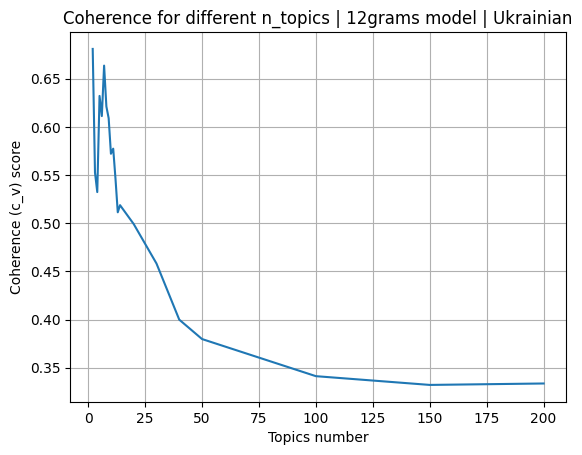

In [18]:
plt.plot(topic_numbers_12grams, coherences_12grams)
plt.title('Coherence for different n_topics | 12grams model | Ukrainian')
plt.xlabel('Topics number')
plt.ylabel('Coherence (c_v) score')
plt.grid()
plt.show()

## 1- and 2-grams no lemmatization: optimal topics number

Model that uses both 1- and 2-grams with no lemmatization for the different topics numbers for the data for September 2022 in Ukrainian language.

In [19]:
class UkrainianPreprocessor:
    def preprocess_documents(self, documents_list: list, return_strings: bool = True):
        return [self.preprocess(doc, return_string=return_strings) for doc in documents_list]
    
    # Function to preprocess documents
    def preprocess(self, document, return_string: bool = True):
        # Tokenize
        document = self.remove_links_content(document)
        document = self.remove_emails(document)
        document = self.remove_multiple_space(document)
        document = self.remove_hashtags(document)
        document = self.remove_punctuation(document)
        document = self.remove_multiple_space(document)
        
        words = word_tokenize(document.lower())
        # Remove stopwords and punctuations
        filtered_words = [word for word in words if word.isalnum() and not word in stop_words]
        if return_string:
            return ' '.join(filtered_words)
        else:
            return filtered_words
    
    def remove_links_content(self, text):
        text = re.sub(r"http\S+", "", text)
        return text
    
    def remove_emails(self, text):
        return re.sub('\S+@\S*\s?', '', text)
    
    def remove_punctuation(self, text):
        """https://stackoverflow.com/a/37221663"""
        table = str.maketrans({key: None for key in string.punctuation})
        return text.translate(table)
    
    def remove_multiple_space(self, text):
        return re.sub("\s\s+", " ", text)

    def remove_hashtags(self, text):
        old_text = text + '\n'
        new_text = text
        while len(new_text) < len(old_text):
            old_text = new_text
            new_text = re.sub('(?<=[\s\n])#\S+\s*$', '', new_text)
        return new_text

In [20]:
LSAPipeline = LSAPipelineUkrainian(all_documents_0922_uk, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=5, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 random_state=47)
topics = LSAPipeline.run_topics_detection()

In [21]:
topics

[['ебать',
  'ебать путін',
  'ідіть ебать',
  'путін ukrainian',
  'ідіть',
  'ukrainian',
  'путін',
  'україні',
  'ідіть нахуй',
  'росії'],
 ['слава',
  'україні',
  'слава україні',
  'зсу',
  'слава зсу',
  'героям',
  'україні слава',
  'ukraine',
  'героям слава',
  'україні героям'],
 ['війна анімація',
  'отже війна',
  'анімація',
  'отже',
  'війна',
  'шо',
  'україна',
  'ukraine',
  'всі',
  'закінчиться'],
 ['підписатись',
  'дня соловїною',
  'підписатись адвокат',
  'соловїною підписатись',
  'соловїною',
  'адвокат',
  'дня',
  'кожного дня',
  'кожного',
  'гарного'],
 ['фото',
  'ukraine',
  'что',
  'только что',
  'опубликовано',
  'опубликовано фото',
  'что опубликовано',
  'только',
  'kyiv',
  'kyiv ukraine']]

In [22]:
tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
preprocessed_documents = LSAPipeline.import_documents_list

In [23]:
# Convert the list of ngrams into a list of lists of words
texts_v4 = [[word for word in doc.lower().split() if (
    word in tfidf_feature_names)] + tokenize_ngrams(doc, 2) for doc in preprocessed_documents]

# Create a Gensim dictionary
dictionary_v4 = Dictionary(texts_v4)

# Convert the dictionary and the corpus
corpus_v4 = [dictionary_v4.doc2bow(text) for text in texts_v4]

In [69]:
# Calculate the coherence score using Gensim
coherence_model = CoherenceModel(topics=topics,
                                 texts=texts_v4,
                                 dictionary=dictionary_v4,
                                 corpus=corpus_v4,
                                 coherence='c_v')
coherence_score = coherence_model.get_coherence()

print('Coherence Score:', coherence_score)

Coherence Score: 0.6321149420077983


## 1- and 2-grams no lemmatization: optimal topics number

Model that uses both 1- and 2-grams with no lemmatization for the different topics numbers for the data for September 2022 in Ukrainian language.

In [16]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian(preprocessed_documents, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 import_preprocessed_documents=True,
                                 random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v4,
                                     dictionary=dictionary_v4,
                                     corpus=corpus_v4,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.6809041134227105
--Topic number 3 coherence score: 0.5525279450253504
--Topic number 4 coherence score: 0.53230184193736
--Topic number 5 coherence score: 0.6321149420077983
--Topic number 6 coherence score: 0.6111898822710554
--Topic number 7 coherence score: 0.6635846666650449
--Topic number 8 coherence score: 0.6211509734536742
--Topic number 9 coherence score: 0.6090182257767875
--Topic number 10 coherence score: 0.5720475065902724
--Topic number 11 coherence score: 0.5773671073803661
--Topic number 12 coherence score: 0.546130195091591
--Topic number 13 coherence score: 0.511296396917588
--Topic number 14 coherence score: 0.5187133260182518
--Topic number 20 coherence score: 0.4991199245235597
--Topic number 30 coherence score: 0.45816826394032256
--Topic number 40 coherence score: 0.39987153328398434
--Topic number 50 coherence score: 0.3797382908369695
--Topic number 100 coherence score: 0.3412006596560729
--Topic number 150 coherence score: 0

In [24]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian(preprocessed_documents, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 import_preprocessed_documents=True,
                                 random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v4,
                                     dictionary=dictionary_v4,
                                     corpus=corpus_v4,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.6735099972158538
--Topic number 3 coherence score: 0.5343935898879323
--Topic number 4 coherence score: 0.5418390566030703
--Topic number 5 coherence score: 0.6214559855858763
--Topic number 6 coherence score: 0.6057975553447934
--Topic number 7 coherence score: 0.6635790161414682
--Topic number 8 coherence score: 0.6195536559213559
--Topic number 9 coherence score: 0.6002691916308364
--Topic number 10 coherence score: 0.5685974253404436
--Topic number 11 coherence score: 0.5722876506565828
--Topic number 12 coherence score: 0.5653359520607235
--Topic number 13 coherence score: 0.5397288347192799
--Topic number 14 coherence score: 0.534143223278431
--Topic number 20 coherence score: 0.4586507826822007
--Topic number 30 coherence score: 0.42096495546298585
--Topic number 40 coherence score: 0.3992217902524409
--Topic number 50 coherence score: 0.38494606398338277
--Topic number 100 coherence score: 0.3402894404075277
--Topic number 150 coherence score

In [25]:
with open('coherences_12grams_uk_no_lemmatization.json','w') as json_file:
    json.dump({'coherences': coherences_12grams,
               'predicted_topics': predicted_topics_counts_12grams}, json_file)

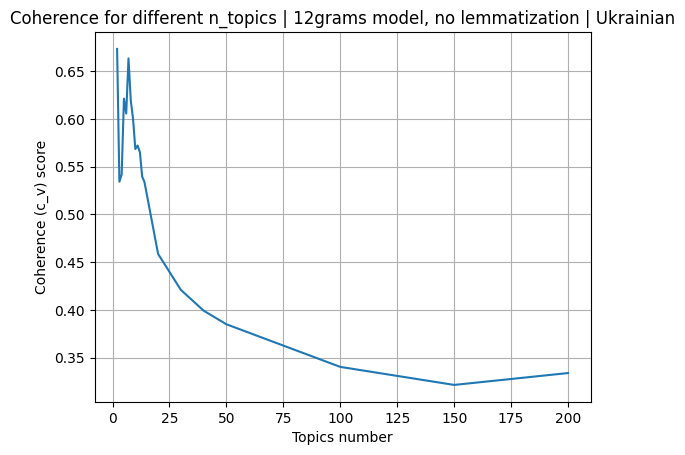

In [26]:
plt.plot(topic_numbers_12grams, coherences_12grams)
plt.title('Coherence for different n_topics | 12grams model, no lemmatization | Ukrainian')
plt.xlabel('Topics number')
plt.ylabel('Coherence (c_v) score')
plt.grid()
plt.show()

# 1- and 2-grams with the new processing with no lemmatization

Model that uses both 1- and 2-grams with the new preprocessing with no lemmatization for the data for September 2022 in Ukrainian language.

In [27]:
import stanza

In [28]:
stanza.download('uk')

2024-03-24 00:21:27 INFO: Downloading default packages for language: uk (Ukrainian) ...
2024-03-24 00:21:27 INFO: File exists: /home/oleksii/stanza_resources/uk/default.zip
2024-03-24 00:21:30 INFO: Finished downloading models and saved to /home/oleksii/stanza_resources.


In [29]:
stanza_pip = stanza.Pipeline(lang='uk', processors='tokenize,mwt,pos,lemma')

2024-03-24 00:21:30 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-03-24 00:21:30 INFO: Loading these models for language: uk (Ukrainian):
| Processor | Package     |
---------------------------
| tokenize  | iu          |
| mwt       | iu          |
| pos       | iu_charlm   |
| lemma     | iu_nocharlm |

2024-03-24 00:21:30 INFO: Using device: cpu
2024-03-24 00:21:30 INFO: Loading: tokenize
2024-03-24 00:21:30 INFO: Loading: mwt
2024-03-24 00:21:30 INFO: Loading: pos
2024-03-24 00:21:31 INFO: Loading: lemma
2024-03-24 00:21:31 INFO: Done loading processors!


In [32]:
# The new preprocessing class is now our main one
class UkrainianPreprocessor:
    def preprocess_documents(self, documents_list: list,
                             return_strings: bool = True,
                             verbose: int = 1):
        preprocessed_documents = []
        for i_d, doc in enumerate(documents_list):
            preprocessed_documents.append(self.preprocess(doc,
                                                          return_string=return_strings))
            if (verbose == 1) and ((i_d == 0) or ((i_d + 1)%100 == 0)):
                print(f'--Preprocessed documents: {i_d+1}/{len(documents_list)}')
        return preprocessed_documents
    
    # Function to preprocess documents
    def preprocess(self, document, return_string: bool = True):
        # Clean the document
        document = self.remove_links_content(document)
        document = self.remove_emails(document)
        document = self.remove_multiple_space(document)
        document = self.remove_hashtags(document)
        document = self.remove_punctuation(document)
        document = self.remove_multiple_space(document)
        
        # Tokenize and lemmatize
        processed_document = stanza_pip(document.lower())
        lemmatized_words = [word.text for sent in processed_document.sentences for word in sent.words]
        # Remove stopwords and punctuations
        filtered_words = [word for word in lemmatized_words if word.isalnum() and not word in stop_words]
        if return_string:
            return ' '.join(filtered_words)
        else:
            return filtered_words
    
    def remove_links_content(self, text):
        text = re.sub(r"http\S+", "", text)
        return text
    
    def remove_emails(self, text):
        return re.sub('\S+@\S*\s?', '', text)
    
    def remove_punctuation(self, text):
        """https://stackoverflow.com/a/37221663"""
        table = str.maketrans({key: None for key in string.punctuation})
        return text.translate(table)
    
    def remove_multiple_space(self, text):
        return re.sub("\s\s+", " ", text)

    def remove_hashtags(self, text):
        old_text = text + '\n'
        new_text = text
        while len(new_text) < len(old_text):
            old_text = new_text
            new_text = re.sub('(?<=[\s\n])#\S+\s*$', '', new_text)
        return new_text

In [33]:
LSAPipeline_new = LSAPipelineUkrainian(all_documents_0922_uk, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=5, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 random_state=47)
topics = LSAPipeline_new.run_topics_detection()

--Preprocessed documents: 1/98087
--Preprocessed documents: 100/98087
--Preprocessed documents: 200/98087
--Preprocessed documents: 300/98087
--Preprocessed documents: 400/98087
--Preprocessed documents: 500/98087
--Preprocessed documents: 600/98087
--Preprocessed documents: 700/98087
--Preprocessed documents: 800/98087
--Preprocessed documents: 900/98087
--Preprocessed documents: 1000/98087
--Preprocessed documents: 1100/98087
--Preprocessed documents: 1200/98087
--Preprocessed documents: 1300/98087
--Preprocessed documents: 1400/98087
--Preprocessed documents: 1500/98087
--Preprocessed documents: 1600/98087
--Preprocessed documents: 1700/98087
--Preprocessed documents: 1800/98087
--Preprocessed documents: 1900/98087
--Preprocessed documents: 2000/98087
--Preprocessed documents: 2100/98087
--Preprocessed documents: 2200/98087
--Preprocessed documents: 2300/98087
--Preprocessed documents: 2400/98087
--Preprocessed documents: 2500/98087
--Preprocessed documents: 2600/98087
--Preprocesse

/home/oleksii/UCU/ucu_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['дев', 'ласка', 'разу', 'ятий', 'ятнадцятий', 'ятнадцять', 'ять', 'ім'] not in stop_words.
  warnings.warn(


In [34]:
with open('preprocessed_documents_092022_uk_new_no_lemmatization.json','w') as json_file:
    json.dump({'preprocessed_documents': LSAPipeline_new.import_documents_list}, json_file)

In [35]:
topics

[['ебать путін',
  'путін ukrainian',
  'ідіть ебать',
  'ебать',
  'ідіть',
  'ukrainian',
  'путін',
  'україні',
  'україни',
  'ідіть нахуй'],
 ['слава',
  'україні',
  'слава україні',
  'зсу',
  'слава зсу',
  'героям',
  'ukraine',
  'україні слава',
  'героям слава',
  'україна'],
 ['війна анімація',
  'отже війна',
  'анімація',
  'отже',
  'війна',
  'бо',
  'шо',
  'всі',
  'закінчиться',
  'ukraine'],
 ['підписатись',
  'дня соловїною',
  'соловїною підписатись',
  'підписатись адвокат',
  'соловїною',
  'адвокат',
  'дня',
  'кожного дня',
  'кожного',
  'гарного'],
 ['фото',
  'ukraine',
  'что',
  'опубликовано',
  'опубликовано фото',
  'только что',
  'что опубликовано',
  'только',
  'kyiv',
  'kyiv ukraine']]

In [41]:
tfidf_feature_names = set(LSAPipeline_new.tfidf_vectorizer.get_feature_names_out())
preprocessed_documents = LSAPipeline_new.import_documents_list

In [42]:
# Convert the list of ngrams into a list of lists of words
texts_v5 = [[word for word in doc.lower().split() if (
    word in tfidf_feature_names)] + tokenize_ngrams(doc, 2) for doc in preprocessed_documents]

# Create a Gensim dictionary
dictionary_v5 = Dictionary(texts_v5)

# Convert the dictionary and the corpus
corpus_v5 = [dictionary_v5.doc2bow(text) for text in texts_v5]

## 1- and 2-grams with the new processing with no lemmatization: optimal topics number

Model that uses both 1- and 2-grams with the new preprocessing with no lemmatization for the different topics numbers for the data for September 2022 in Ukrainian language.

In [96]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian(preprocessed_documents, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 import_preprocessed_documents=True, random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v5,
                                     dictionary=dictionary_v5,
                                     corpus=corpus_v5,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.2905581531479207
--Topic number 3 coherence score: 0.45424678594613993
--Topic number 4 coherence score: 0.4150800549832757
--Topic number 5 coherence score: 0.39171220461669504
--Topic number 6 coherence score: 0.36887492764260915
--Topic number 7 coherence score: 0.3380657789739235
--Topic number 8 coherence score: 0.3546118252105634
--Topic number 9 coherence score: 0.32192364300863274
--Topic number 10 coherence score: 0.41119238838525973
--Topic number 11 coherence score: 0.3754787345168653
--Topic number 12 coherence score: 0.43095501686306004
--Topic number 13 coherence score: 0.4285081254892302
--Topic number 14 coherence score: 0.4132330129657908
--Topic number 20 coherence score: 0.4094406225738248
--Topic number 30 coherence score: 0.4344411516916182
--Topic number 40 coherence score: 0.4212844870544674
--Topic number 50 coherence score: 0.42003906935361407
--Topic number 100 coherence score: 0.3850433513994528
--Topic number 150 coherence

In [38]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian(preprocessed_documents, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 import_preprocessed_documents=True, random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v5,
                                     dictionary=dictionary_v5,
                                     corpus=corpus_v5,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.6735099972158538
--Topic number 3 coherence score: 0.5343935898879323
--Topic number 4 coherence score: 0.5418390566030703
--Topic number 5 coherence score: 0.6214559855858763
--Topic number 6 coherence score: 0.6057975553447934
--Topic number 7 coherence score: 0.6635790161414682
--Topic number 8 coherence score: 0.6195536559213559
--Topic number 9 coherence score: 0.6002691916308364
--Topic number 10 coherence score: 0.5685974253404436
--Topic number 11 coherence score: 0.5722876506565828
--Topic number 12 coherence score: 0.5653359520607235
--Topic number 13 coherence score: 0.5397288347192799
--Topic number 14 coherence score: 0.534143223278431
--Topic number 20 coherence score: 0.4586507826822007
--Topic number 30 coherence score: 0.42096495546298585
--Topic number 40 coherence score: 0.3992217902524409
--Topic number 50 coherence score: 0.38494606398338277
--Topic number 100 coherence score: 0.3402894404075277
--Topic number 150 coherence score

In [43]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian(preprocessed_documents, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 import_preprocessed_documents=True, random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v5,
                                     dictionary=dictionary_v5,
                                     corpus=corpus_v5,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.6748907885186981
--Topic number 3 coherence score: 0.5491588593663551
--Topic number 4 coherence score: 0.5379063476891628
--Topic number 5 coherence score: 0.6179176461033132
--Topic number 6 coherence score: 0.599169394729979
--Topic number 7 coherence score: 0.6610709315317317
--Topic number 8 coherence score: 0.6261033491737189
--Topic number 9 coherence score: 0.5894062841521309
--Topic number 10 coherence score: 0.5662421992881809
--Topic number 11 coherence score: 0.577966483259598
--Topic number 12 coherence score: 0.5342171239965691
--Topic number 13 coherence score: 0.5584374676807189
--Topic number 14 coherence score: 0.5024845203273294
--Topic number 20 coherence score: 0.46625184721182206
--Topic number 30 coherence score: 0.40085631723653226
--Topic number 40 coherence score: 0.3807775685249146
--Topic number 50 coherence score: 0.3557342355410759
--Topic number 100 coherence score: 0.3362531727809076
--Topic number 150 coherence score:

In [44]:
with open('coherences_12grams_uk_new_no_lemmatization.json','w') as json_file:
    json.dump({'coherences': coherences_12grams,
               'predicted_topics': predicted_topics_counts_12grams}, json_file)

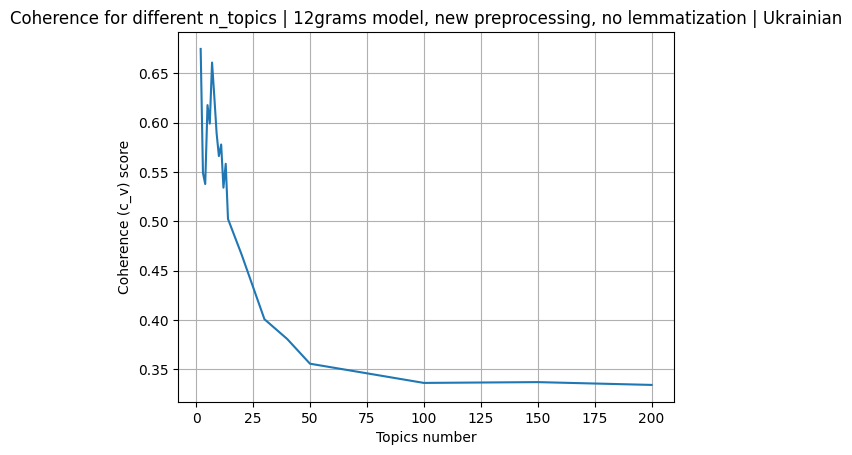

In [45]:
plt.plot(topic_numbers_12grams, coherences_12grams)
plt.title('Coherence for different n_topics | 12grams model, new preprocessing, no lemmatization | Ukrainian')
plt.xlabel('Topics number')
plt.ylabel('Coherence (c_v) score')
plt.grid()
plt.show()

# 1- and 2-grams with the new processing

Model that uses both 1- and 2-grams with the new preprocessing for the data for September 2022 in Ukrainian language.

In [46]:
# The new preprocessing class is now our main one
class UkrainianPreprocessor:
    def preprocess_documents(self, documents_list: list,
                             return_strings: bool = True,
                             verbose: int = 1):
        preprocessed_documents = []
        for i_d, doc in enumerate(documents_list):
            preprocessed_documents.append(self.preprocess(doc,
                                                          return_string=return_strings))
            if (verbose == 1) and ((i_d == 0) or ((i_d + 1)%100 == 0)):
                print(f'--Preprocessed documents: {i_d+1}/{len(documents_list)}')
        return preprocessed_documents
    
    # Function to preprocess documents
    def preprocess(self, document, return_string: bool = True):
        # Clean the document
        document = self.remove_links_content(document)
        document = self.remove_emails(document)
        document = self.remove_multiple_space(document)
        document = self.remove_hashtags(document)
        document = self.remove_punctuation(document)
        document = self.remove_multiple_space(document)
        
        # Tokenize and lemmatize
        processed_document = stanza_pip(document.lower())
        lemmatized_words = [word.lemma for sent in processed_document.sentences for word in sent.words]
        # Remove stopwords and punctuations
        filtered_words = [word for word in lemmatized_words if word.isalnum() and not word in stop_words]
        if return_string:
            return ' '.join(filtered_words)
        else:
            return filtered_words
    
    def remove_links_content(self, text):
        text = re.sub(r"http\S+", "", text)
        return text
    
    def remove_emails(self, text):
        return re.sub('\S+@\S*\s?', '', text)
    
    def remove_punctuation(self, text):
        """https://stackoverflow.com/a/37221663"""
        table = str.maketrans({key: None for key in string.punctuation})
        return text.translate(table)
    
    def remove_multiple_space(self, text):
        return re.sub("\s\s+", " ", text)

    def remove_hashtags(self, text):
        old_text = text + '\n'
        new_text = text
        while len(new_text) < len(old_text):
            old_text = new_text
            new_text = re.sub('(?<=[\s\n])#\S+\s*$', '', new_text)
        return new_text

In [47]:
LSAPipeline_new = LSAPipelineUkrainian(all_documents_0922_uk, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=5, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 random_state=47)
topics = LSAPipeline_new.run_topics_detection()

--Preprocessed documents: 1/98087
--Preprocessed documents: 100/98087
--Preprocessed documents: 200/98087
--Preprocessed documents: 300/98087
--Preprocessed documents: 400/98087
--Preprocessed documents: 500/98087
--Preprocessed documents: 600/98087
--Preprocessed documents: 700/98087
--Preprocessed documents: 800/98087
--Preprocessed documents: 900/98087
--Preprocessed documents: 1000/98087
--Preprocessed documents: 1100/98087
--Preprocessed documents: 1200/98087
--Preprocessed documents: 1300/98087
--Preprocessed documents: 1400/98087
--Preprocessed documents: 1500/98087
--Preprocessed documents: 1600/98087
--Preprocessed documents: 1700/98087
--Preprocessed documents: 1800/98087
--Preprocessed documents: 1900/98087
--Preprocessed documents: 2000/98087
--Preprocessed documents: 2100/98087
--Preprocessed documents: 2200/98087
--Preprocessed documents: 2300/98087
--Preprocessed documents: 2400/98087
--Preprocessed documents: 2500/98087
--Preprocessed documents: 2600/98087
--Preprocesse

In [48]:
with open('preprocessed_documents_092022_uk_new_v2.json','w') as json_file:
    json.dump({'preprocessed_documents': LSAPipeline_new.import_documents_list}, json_file)

In [49]:
topics

[['путін ukrainian',
  'ебать путін',
  'іти ебать',
  'ебать',
  'ukrainian',
  'іти',
  'путін',
  'україна',
  'війна',
  'росія'],
 ['дякувати',
  'україна',
  'слава',
  'зса',
  'те',
  'приємно',
  'пане',
  'знати',
  'підтримка',
  'слава україна'],
 ['україна',
  'слава',
  'слава україна',
  'зса',
  'війна',
  'ukraine',
  'герой',
  'свій',
  'росія',
  'російський'],
 ['війна',
  'отже війна',
  'війна анімація',
  'анімація',
  'отже',
  'шо',
  'те',
  'свій',
  'знати',
  'бо'],
 ['підписатися адвокат',
  'соловїна підписатися',
  'соловїна',
  'адвокат',
  'підписатися',
  'шо',
  'підписатися via',
  'via',
  'робити',
  'бо']]

In [50]:
tfidf_feature_names = set(LSAPipeline_new.tfidf_vectorizer.get_feature_names_out())
preprocessed_documents = LSAPipeline_new.import_documents_list

In [51]:
# Convert the list of ngrams into a list of lists of words
texts_v5 = [[word for word in doc.lower().split() if (
    word in tfidf_feature_names)] + tokenize_ngrams(doc, 2) for doc in preprocessed_documents]

# Create a Gensim dictionary
dictionary_v5 = Dictionary(texts_v5)

# Convert the dictionary and the corpus
corpus_v5 = [dictionary_v5.doc2bow(text) for text in texts_v5]

## 1- and 2-grams with the new processing: optimal topics number

Model that uses both 1- and 2-grams with the new preprocessing for the different topics numbers for the data for September 2022 in Ukrainian language.

In [43]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian(preprocessed_documents, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 import_preprocessed_documents=True, random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v5,
                                     dictionary=dictionary_v5,
                                     corpus=corpus_v5,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.6748907885186981
--Topic number 3 coherence score: 0.5491588593663551
--Topic number 4 coherence score: 0.5379063476891628
--Topic number 5 coherence score: 0.6179176461033132
--Topic number 6 coherence score: 0.599169394729979
--Topic number 7 coherence score: 0.6610709315317317
--Topic number 8 coherence score: 0.6261033491737189
--Topic number 9 coherence score: 0.5894062841521309
--Topic number 10 coherence score: 0.5662421992881809
--Topic number 11 coherence score: 0.577966483259598
--Topic number 12 coherence score: 0.5342171239965691
--Topic number 13 coherence score: 0.5584374676807189
--Topic number 14 coherence score: 0.5024845203273294
--Topic number 20 coherence score: 0.46625184721182206
--Topic number 30 coherence score: 0.40085631723653226
--Topic number 40 coherence score: 0.3807775685249146
--Topic number 50 coherence score: 0.3557342355410759
--Topic number 100 coherence score: 0.3362531727809076
--Topic number 150 coherence score:

In [52]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian(preprocessed_documents, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 import_preprocessed_documents=True, random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v5,
                                     dictionary=dictionary_v5,
                                     corpus=corpus_v5,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.440511188918085
--Topic number 3 coherence score: 0.4773186484977838
--Topic number 4 coherence score: 0.4080216495154205
--Topic number 5 coherence score: 0.3943176825716894
--Topic number 6 coherence score: 0.47505141636918663
--Topic number 7 coherence score: 0.5008945459524982
--Topic number 8 coherence score: 0.4785636243967861
--Topic number 9 coherence score: 0.524712115396686
--Topic number 10 coherence score: 0.4841622803367537
--Topic number 11 coherence score: 0.4789718948284168
--Topic number 12 coherence score: 0.47711179072947063
--Topic number 13 coherence score: 0.49781712968487124
--Topic number 14 coherence score: 0.48429582977411606
--Topic number 20 coherence score: 0.49232716493605116
--Topic number 30 coherence score: 0.45820287371849433
--Topic number 40 coherence score: 0.4368574278128879
--Topic number 50 coherence score: 0.433120402542279
--Topic number 100 coherence score: 0.3905009616706967
--Topic number 150 coherence sco

In [53]:
with open('coherences_12grams_uk_new_v2.json','w') as json_file:
    json.dump({'coherences': coherences_12grams,
               'predicted_topics': predicted_topics_counts_12grams}, json_file)

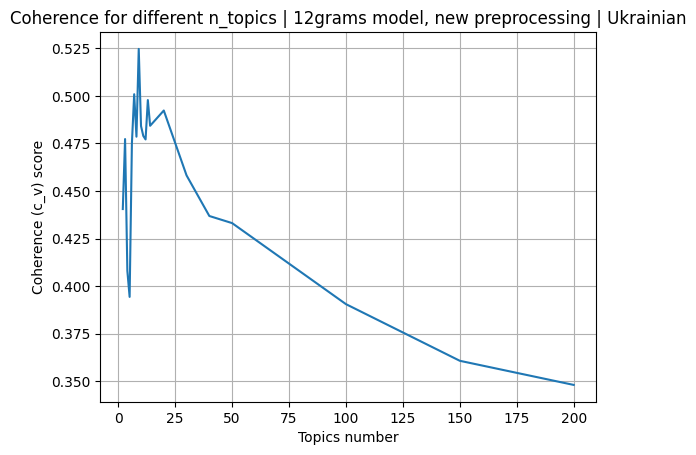

In [54]:
plt.plot(topic_numbers_12grams, coherences_12grams)
plt.title('Coherence for different n_topics | 12grams model, new preprocessing | Ukrainian')
plt.xlabel('Topics number')
plt.ylabel('Coherence (c_v) score')
plt.grid()
plt.show()

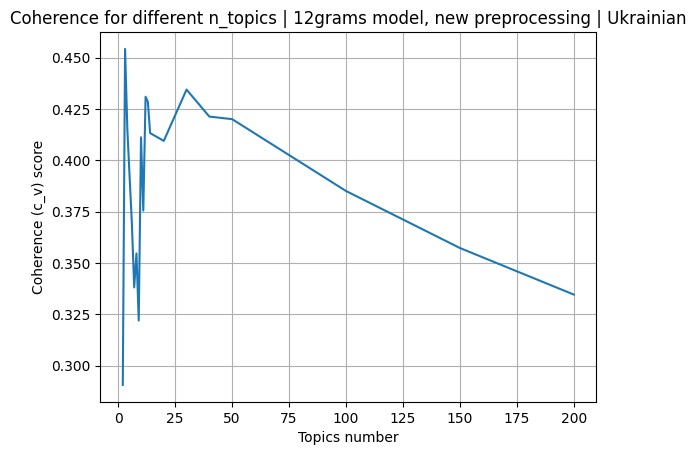

In [98]:
plt.plot(topic_numbers_12grams, coherences_12grams)
plt.title('Coherence for different n_topics | 12grams model, new preprocessing | Ukrainian')
plt.xlabel('Topics number')
plt.ylabel('Coherence (c_v) score')
plt.grid()
plt.show()

## 1- and 2-grams with the new processing, only certain PoS, with no lemmatization

Model that uses both 1- and 2-grams with the new preprocessing only for the certain most important parts of speech (PoS) with no lemmatization for the data for September 2022 in Ukrainian language.

In [55]:
class UkrainianPreprocessor_v3:
    def preprocess_documents(self, documents_list: list,
                             filter_by_pos: list = [], return_strings: bool = True,
                             verbose: int = 0):
        preprocessed_documents = []
        for i_d, doc in enumerate(documents_list):
            preprocessed_documents.append(self.preprocess(doc,
                                                          filter_by_pos=filter_by_pos,
                                                          return_string=return_strings))
            if (verbose == 1) and ((i_d == 0) or ((i_d + 1)%100 == 0)):
                print(f'--Preprocessed documents: {i_d+1}/{len(documents_list)}')
        return preprocessed_documents
    
    # Function to preprocess documents
    def preprocess(self, document, filter_by_pos: list = [], return_string: bool = True):
        # Clean the document
        document = self.remove_links_content(document)
        document = self.remove_emails(document)
        document = self.remove_multiple_space(document)
        document = self.remove_hashtags(document)
        document = self.remove_punctuation(document)
        document = self.remove_multiple_space(document)
        
        # Tokenize and lemmatize
        processed_document = stanza_pip(document.lower())
        if len(filter_by_pos) > 0:
            lemmatized_words = [word.text for sent in processed_document.sentences for word in sent.words if (
                word.upos in filter_by_pos)]
        else:
            lemmatized_words = [word.text for sent in processed_document.sentences for word in sent.words]
        # Remove stopwords and punctuations
        filtered_words = [word for word in lemmatized_words if word.isalnum() and not word in stop_words]
        if return_string:
            return ' '.join(filtered_words)
        else:
            return filtered_words
    
    def remove_links_content(self, text):
        text = re.sub(r"http\S+", "", text)
        return text
    
    def remove_emails(self, text):
        return re.sub('\S+@\S*\s?', '', text)
    
    def remove_punctuation(self, text):
        """https://stackoverflow.com/a/37221663"""
        table = str.maketrans({key: None for key in string.punctuation})
        return text.translate(table)
    
    def remove_multiple_space(self, text):
        return re.sub("\s\s+", " ", text)

    def remove_hashtags(self, text):
        old_text = text + '\n'
        new_text = text
        while len(new_text) < len(old_text):
            old_text = new_text
            new_text = re.sub('(?<=[\s\n])#\S+\s*$', '', new_text)
        return new_text

In [56]:
class LSAPipelineUkrainian_v3:
    def __init__(self, documents_list, tf_idf_max_df=1.0, tf_idf_min_df=1,
                 lsa_components: int = 100, svd_n_iter: int = 5,
                 n_top_words: int = 10, ngram_range: tuple = (1, 1),
                 filter_by_pos: list = [], random_state: int = -1,
                 import_preprocessed_documents: bool = False, verbose: int = 0):
        if not import_preprocessed_documents:
            self.import_documents_list = UkrainianPreprocessor_v3().preprocess_documents(documents_list,
                                                                                         filter_by_pos=filter_by_pos,
                                                                                         verbose=verbose)
        else:
            self.import_documents_list = documents_list
        self.tf_idf_max_df = tf_idf_max_df
        self.tf_idf_min_df = tf_idf_min_df
        self.lsa_components = lsa_components
        self.svd_n_iter = svd_n_iter
        self.n_top_words = n_top_words
        self.ngram_range = ngram_range
        self.random_state = random_state
        self.coherence_texts_calculated = False
        self.verbose = verbose

    def run_topics_detection(self):
        tfidf_documents = self.TF_IDF()
        if self.verbose == 1:
            print(f'--LSA topics detection: TF-IDF calculated')
        self.TruncatedSVD(tfidf_documents)
        if self.verbose == 1:
            print(f'--LSA topics detection: truncated SVD calculated')
        self.topics = self.find_topics()
        return self.topics

    def transform_documents(self, new_documents_list: list):
        return list(map(np.argmax, self.svd_model.transform(
            self.tfidf_vectorizer.transform(new_documents_list))))

    def import_ready_documents(self, documents_list, texts, dictionary, corpus):
        self.import_documents_list = documents_list
        self.texts = texts
        self.dictionary = dictionary
        self.corpus = corpus
        self.coherence_texts_calculated = True

    def TF_IDF(self):
        self.tfidf_vectorizer = TfidfVectorizer(max_df=self.tf_idf_max_df,
                                                min_df=self.tf_idf_min_df,
                                                ngram_range=self.ngram_range,
                                                stop_words=stop_words)
        return self.tfidf_vectorizer.fit_transform(self.import_documents_list)
        # tfidf_feature_names = self.tfidf_vectorizer.get_feature_names_out()
    
    def TruncatedSVD(self, tfidf_documents):
        if self.random_state != -1:
            self.svd_model = TruncatedSVD(n_components=self.lsa_components,
                                 n_iter=self.svd_n_iter, random_state=self.random_state)
        else:
            self.svd_model = TruncatedSVD(n_components=self.lsa_components,
                                 n_iter=self.svd_n_iter)
        self.svd_model.fit_transform(tfidf_documents)

    def find_topics(self):
        # Extract the top words for each topic
        topics = []
        tfidf_feature_names = self.tfidf_vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(self.svd_model.components_):
            top_features_ind = topic.argsort()[:-self.n_top_words - 1:-1]
            top_features = [tfidf_feature_names[i] for i in top_features_ind]
            topics.append(top_features)
        return topics

    def calculate_coherence_score(self, recalculate_texts: bool = False, verbose: int = 0):
        if not self.coherence_texts_calculated or recalculate_texts:
            self.calculate_coherence_texts(verbose=verbose)
        # Calculate the coherence score using Gensim
        coherence_model = CoherenceModel(topics=self.topics,
                                         texts=self.texts,
                                         dictionary=self.dictionary,
                                         coherence='c_v')
        if verbose == 1:
            print(f'--Calculating the coherence score')
        self.coherence_score = coherence_model.get_coherence()
        return self.coherence_score

    def calculate_coherence_texts(self, verbose: int = 0):
        # Convert the list of top words into a list of lists of words
        tfidf_feature_names = set(self.tfidf_vectorizer.get_feature_names_out())
        if verbose == 1:
            print(f'--Starting forming the texts')
        self.texts = [[word for word in doc.lower().split() if (
            word in tfidf_feature_names)] for doc in self.import_documents_list]
        # Create a Gensim dictionary
        if verbose == 1:
            print(f'--Creating the Gensim dectionary')
        self.dictionary = Dictionary(self.texts)
        # Convert the dictionary and the corpus
        if verbose == 1:
            print(f'--Converting to the corpus')
        self.corpus = [self.dictionary.doc2bow(text) for text in self.texts]
        self.coherence_texts_calculated = True

In [57]:
LSAPipeline = LSAPipelineUkrainian_v3(all_documents_0922_uk, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=5, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 filter_by_pos=['NOUN','PNOUN','VERB','ADJ','ADV'],
                                 random_state=47, verbose=1)
topics = LSAPipeline.run_topics_detection()

--Preprocessed documents: 1/98087
--Preprocessed documents: 100/98087
--Preprocessed documents: 200/98087
--Preprocessed documents: 300/98087
--Preprocessed documents: 400/98087
--Preprocessed documents: 500/98087
--Preprocessed documents: 600/98087
--Preprocessed documents: 700/98087
--Preprocessed documents: 800/98087
--Preprocessed documents: 900/98087
--Preprocessed documents: 1000/98087
--Preprocessed documents: 1100/98087
--Preprocessed documents: 1200/98087
--Preprocessed documents: 1300/98087
--Preprocessed documents: 1400/98087
--Preprocessed documents: 1500/98087
--Preprocessed documents: 1600/98087
--Preprocessed documents: 1700/98087
--Preprocessed documents: 1800/98087
--Preprocessed documents: 1900/98087
--Preprocessed documents: 2000/98087
--Preprocessed documents: 2100/98087
--Preprocessed documents: 2200/98087
--Preprocessed documents: 2300/98087
--Preprocessed documents: 2400/98087
--Preprocessed documents: 2500/98087
--Preprocessed documents: 2600/98087
--Preprocesse

In [58]:
with open('preprocessed_documents_092022_uk_new_pos_no_lemmatization.json','w') as json_file:
    json.dump({'preprocessed_documents': LSAPipeline.import_documents_list}, json_file)

In [102]:
with open('preprocessed_documents_092022_uk_new_pos_no_lemmatization.json','r') as json_file:
    preprocessed_documents_pos = json.load(json_file)['preprocessed_documents']

In [105]:
preprocessed_documents_pos[0]

'міноборони передати парламент пропозиція зміна закон військовий добровільність постановка військовий облік жінка'

In [83]:
topics

[['дякувати',
  'приємно',
  'дякувати підтримка',
  'підтримка',
  'пане',
  'зса',
  'слава',
  'дякувати зса',
  'дякувати пане',
  'пані'],
 ['іти ебать',
  'ебать путін',
  'ебать',
  'іти',
  'путін',
  'війна',
  'росія',
  'росіянин',
  'нахувати',
  'іти нахувати'],
 ['слава',
  'герой',
  'зса',
  'слава герой',
  'слава зса',
  'герой слава',
  'слава слава',
  'воїн',
  'слава воїн',
  'смерть'],
 ['війна',
  'війна анімація',
  'анімація',
  'знати',
  'думати',
  'робити',
  'росія',
  'бачити',
  'російський',
  'немати'],
 ['підписатися',
  'соловїна',
  'соловїна підписатися',
  'підписатися адвокат',
  'адвокат',
  'чекати',
  'казати',
  'зса',
  'писати',
  'публікувати світлина']]

In [59]:
topics

[['ідіть ебать',
  'ебать путін',
  'ебать',
  'ідіть',
  'путін',
  'росії',
  'ідіть нахуй',
  'росія',
  'війну',
  'мобілізацію'],
 ['слава',
  'зсу',
  'слава зсу',
  'героям',
  'слава слава',
  'слава героям',
  'героям слава',
  'воїнам',
  'слава воїнам',
  'смерть'],
 ['війна',
  'анімація',
  'війна анімація',
  'зсу',
  'війни',
  'закінчиться',
  'цікаво',
  'росії',
  'дня',
  'війна закінчиться'],
 ['дня',
  'підписатись',
  'соловїною',
  'адвокат',
  'дня соловїною',
  'підписатись адвокат',
  'соловїною підписатись',
  'розумію',
  'гарного',
  'гарного дня'],
 ['опубликовано',
  'фото',
  'опубликовано фото',
  'точно',
  'розумію',
  'знаю',
  'відео',
  'харків',
  'пані',
  'дніпро']]

In [60]:
tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
preprocessed_documents = LSAPipeline.import_documents_list

In [61]:
# Convert the list of ngrams into a list of lists of words
texts_v6 = [[word for word in doc.lower().split() if (
    word in tfidf_feature_names)] + tokenize_ngrams(doc, 2) for doc in preprocessed_documents]

# Create a Gensim dictionary
dictionary_v6 = Dictionary(texts_v6)

# Convert the dictionary and the corpus
corpus_v6 = [dictionary_v4.doc2bow(text) for text in texts_v6]

## 1- and 2-grams with the new processing, only certain PoS, with no lemmatization: optimal topics number

Model that uses both 1- and 2-grams with the new preprocessing only for the certain most important parts of speech (PoS) with no lemmatization for the different topics numbers for the data for September 2022 in Ukrainian language.

In [62]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian_v3(preprocessed_documents, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 filter_by_pos=['NOUN','PNOUN','VERB','ADJ','ADV'],
                                 import_preprocessed_documents=True, random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v4,
                                     dictionary=dictionary_v4,
                                     corpus=corpus_v4,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.4644292536969778
--Topic number 3 coherence score: 0.40842238252649293
--Topic number 4 coherence score: 0.43286122141529726
--Topic number 5 coherence score: 0.3788095760914524
--Topic number 6 coherence score: 0.4551729714569557
--Topic number 7 coherence score: 0.5095306388757452
--Topic number 8 coherence score: 0.482698338761065
--Topic number 9 coherence score: 0.46732582638135056
--Topic number 10 coherence score: 0.44936150549944615
--Topic number 11 coherence score: 0.4226039289217452
--Topic number 12 coherence score: 0.42498153832083263
--Topic number 13 coherence score: 0.4241922638140489
--Topic number 14 coherence score: 0.4580185237332795
--Topic number 20 coherence score: 0.4617397884588524
--Topic number 30 coherence score: 0.43481518377765355
--Topic number 40 coherence score: 0.37455651346434643
--Topic number 50 coherence score: 0.371077332828121
--Topic number 100 coherence score: 0.33905627434365565
--Topic number 150 coherence 

In [63]:
topics_12grams

[['ідіть ебать',
  'ебать путін',
  'ебать',
  'ідіть',
  'путін',
  'росії',
  'ідіть нахуй',
  'росія',
  'війну',
  'мобілізацію'],
 ['слава',
  'зсу',
  'слава зсу',
  'героям',
  'слава слава',
  'слава героям',
  'героям слава',
  'воїнам',
  'слава воїнам',
  'смерть'],
 ['війна',
  'анімація',
  'війна анімація',
  'зсу',
  'закінчиться',
  'війни',
  'росії',
  'війна закінчиться',
  'втрати',
  'противника'],
 ['дня',
  'підписатись',
  'соловїною',
  'адвокат',
  'підписатись адвокат',
  'дня соловїною',
  'соловїною підписатись',
  'гарного',
  'гарного дня',
  'доброго'],
 ['опубликовано',
  'фото',
  'опубликовано фото',
  'харків',
  'дніпро',
  'зсу',
  'друк',
  'одязі',
  'хочу',
  'спорткомплекс'],
 ['світлину',
  'публікує світлину',
  'публікує',
  'світлину жива',
  'жива парафія',
  'парафія',
  'жива',
  'заповідник',
  'світлину карпатський',
  'карпатський біосферний'],
 ['зсу',
  'допоможе',
  'ляже',
  'тіло ляже',
  'ґрунт',
  'тіло',
  'ґрунт допоможе',
  

In [64]:
with open('coherences_12grams_uk_new_pos_no_lemmatization.json','w') as json_file:
    json.dump({'coherences': coherences_12grams,
               'predicted_topics': predicted_topics_counts_12grams}, json_file)

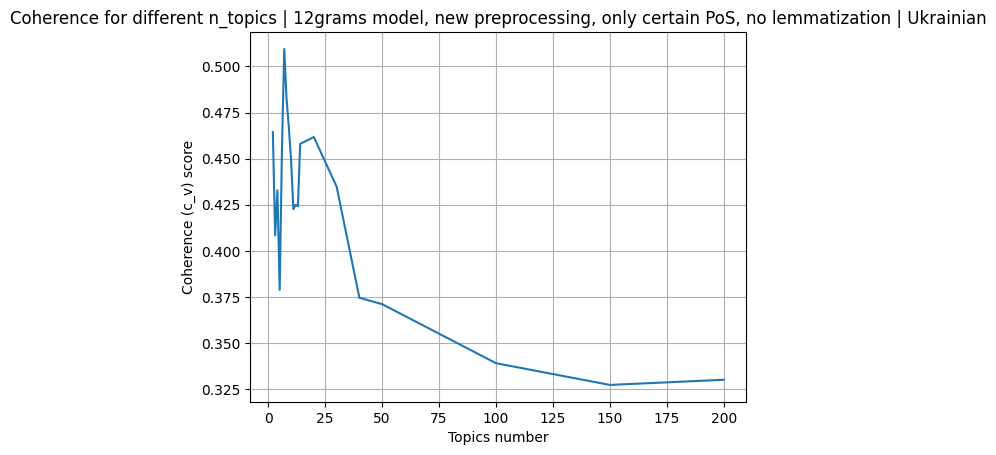

In [65]:
plt.plot(topic_numbers_12grams, coherences_12grams)
plt.title('Coherence for different n_topics | 12grams model, new preprocessing, only certain PoS, no lemmatization | Ukrainian')
plt.xlabel('Topics number')
plt.ylabel('Coherence (c_v) score')
plt.grid()
plt.show()

## 1- and 2-grams with the new processing, only certain PoS, only for the nouns and verbs

Model that uses both 1- and 2-grams with the new preprocessing only for the certain most important parts of speech (PoS) only for the nouns and verbs for the data for September 2022 in Ukrainian language.

In [106]:
LSAPipeline = LSAPipelineUkrainian_v3(all_documents_0922_uk, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=5, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 filter_by_pos=['NOUN','PNOUN','VERB'],
                                 random_state=47, verbose=1)
topics = LSAPipeline.run_topics_detection()

--Preprocessed documents: 1/98087
--Preprocessed documents: 100/98087
--Preprocessed documents: 200/98087
--Preprocessed documents: 300/98087
--Preprocessed documents: 400/98087
--Preprocessed documents: 500/98087
--Preprocessed documents: 600/98087
--Preprocessed documents: 700/98087
--Preprocessed documents: 800/98087
--Preprocessed documents: 900/98087
--Preprocessed documents: 1000/98087
--Preprocessed documents: 1100/98087
--Preprocessed documents: 1200/98087
--Preprocessed documents: 1300/98087
--Preprocessed documents: 1400/98087
--Preprocessed documents: 1500/98087
--Preprocessed documents: 1600/98087
--Preprocessed documents: 1700/98087
--Preprocessed documents: 1800/98087
--Preprocessed documents: 1900/98087
--Preprocessed documents: 2000/98087
--Preprocessed documents: 2100/98087
--Preprocessed documents: 2200/98087
--Preprocessed documents: 2300/98087
--Preprocessed documents: 2400/98087
--Preprocessed documents: 2500/98087
--Preprocessed documents: 2600/98087
--Preprocesse

In [107]:
with open('preprocessed_documents_092022_uk_new_pos_noun_verb.json','w') as json_file:
    json.dump({'preprocessed_documents': LSAPipeline.import_documents_list}, json_file)

In [108]:
topics

[['дякувати',
  'підтримка',
  'дякувати підтримка',
  'зса',
  'пане',
  'дякувати зса',
  'слава',
  'пані',
  'дякувати пане',
  'знати'],
 ['іти',
  'іти ебать',
  'ебать путін',
  'ебать',
  'путін',
  'війна',
  'росія',
  'росіянин',
  'мобілізація',
  'нахувати'],
 ['слава',
  'герой',
  'зса',
  'слава герой',
  'слава зса',
  'герой слава',
  'слава слава',
  'воїн',
  'слава воїн',
  'перемога'],
 ['знати',
  'війна',
  'анімація',
  'війна анімація',
  'робити',
  'думати',
  'немати',
  'бачити',
  'місто',
  'росія'],
 ['війна',
  'війна анімація',
  'анімація',
  'опубликувати',
  'росія',
  'русня',
  'чекати',
  'місто',
  'початок',
  'вітати']]

In [66]:
with open('preprocessed_documents_092022_uk_new_pos_noun_verb.json','r') as json_file:
    preprocessed_documents_noun_verb = json.load(json_file)['preprocessed_documents']

In [109]:
tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
preprocessed_documents_noun_verb = LSAPipeline.import_documents_list

In [67]:
# Convert the list of ngrams into a list of lists of words
texts_v7 = [[word for word in doc.lower().split() if (
    word in tfidf_feature_names)] + tokenize_ngrams(doc, 2) for doc in preprocessed_documents_noun_verb]

# Create a Gensim dictionary
dictionary_v7 = Dictionary(texts_v7)

# Convert the dictionary and the corpus
corpus_v7 = [dictionary_v4.doc2bow(text) for text in texts_v7]

In [111]:
# Calculate the coherence score using Gensim
coherence_model = CoherenceModel(topics=topics,
                                 texts=texts_v7,
                                 dictionary=dictionary_v7,
                                 corpus=corpus_v7,
                                 coherence='c_v')
coherence_score = coherence_model.get_coherence()

print('Coherence Score:', coherence_score)

Coherence Score: 0.4021543022254982


## 1- and 2-grams with the new processing, only certain PoS, only for the nouns and verbs: optimal topics number

Model that uses both 1- and 2-grams with the new preprocessing only for the certain most important parts of speech (PoS) only for the nouns and verbs for the different topics numbers for the data for September 2022 in Ukrainian language.

In [68]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian_v3(preprocessed_documents_noun_verb, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 filter_by_pos=['NOUN','PNOUN','VERB'],
                                 import_preprocessed_documents=True, random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v7,
                                     dictionary=dictionary_v7,
                                     corpus=corpus_v7,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.32981272745926393
--Topic number 3 coherence score: 0.47960345940109766
--Topic number 4 coherence score: 0.4258940304531826
--Topic number 5 coherence score: 0.3988687218635366
--Topic number 6 coherence score: 0.4297218652423989
--Topic number 7 coherence score: 0.3839543340810864
--Topic number 8 coherence score: 0.35407209848951954
--Topic number 9 coherence score: 0.3707095072640347
--Topic number 10 coherence score: 0.35163969660975847
--Topic number 11 coherence score: 0.3909201036113835
--Topic number 12 coherence score: 0.34847427773288714
--Topic number 13 coherence score: 0.31825161385244854
--Topic number 14 coherence score: 0.3957308753989059
--Topic number 20 coherence score: 0.35614401706150867
--Topic number 30 coherence score: 0.4056192903999282
--Topic number 40 coherence score: 0.4045115314632656
--Topic number 50 coherence score: 0.3671335089864337
--Topic number 100 coherence score: 0.3600217829182921
--Topic number 150 coherence

In [71]:
topics_12grams

[['дякувати',
  'підтримка',
  'дякувати підтримка',
  'зса',
  'пане',
  'дякувати зса',
  'слава',
  'пані',
  'дякувати пане',
  'знати'],
 ['іти',
  'іти ебать',
  'ебать путін',
  'ебать',
  'путін',
  'війна',
  'росія',
  'росіянин',
  'мобілізація',
  'нахувати'],
 ['слава',
  'герой',
  'зса',
  'слава герой',
  'слава зса',
  'герой слава',
  'слава слава',
  'воїн',
  'слава воїн',
  'перемога'],
 ['знати',
  'війна',
  'анімація',
  'війна анімація',
  'робити',
  'думати',
  'бачити',
  'немати',
  'казати',
  'росія'],
 ['війна',
  'війна анімація',
  'анімація',
  'росія',
  'зса',
  'початок',
  'початок війна',
  'перемога',
  'країна',
  'росіянин'],
 ['робити',
  'думати',
  'бачити',
  'немати',
  'зробити',
  'казати',
  'місто',
  'зса',
  'русня',
  'розуміти'],
 ['підписатися',
  'соловїна',
  'підписатися адвокат',
  'соловїна підписатися',
  'адвокат',
  'знати',
  'війна анімація',
  'анімація',
  'війна',
  'рада'],
 ['робити',
  'немати',
  'знати робити',


In [69]:
with open('coherences_12grams_uk_new_pos_nv.json','w') as json_file:
    json.dump({'coherences': coherences_12grams,
               'predicted_topics': predicted_topics_counts_12grams}, json_file)

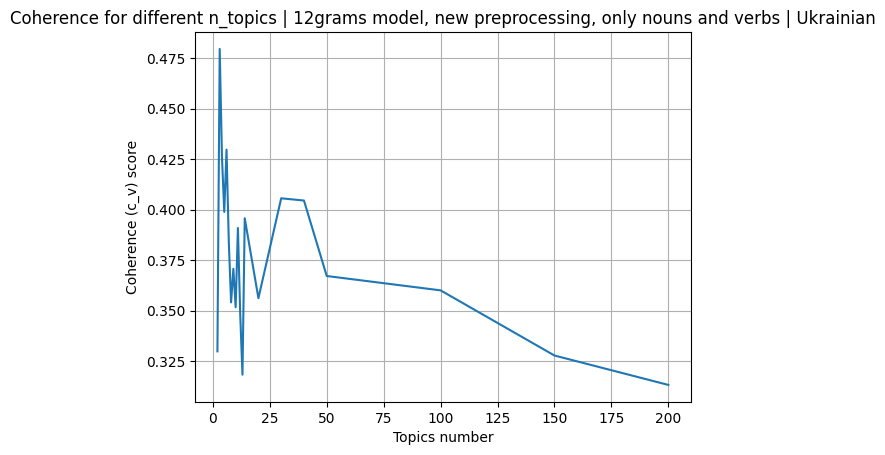

In [70]:
plt.plot(topic_numbers_12grams, coherences_12grams)
plt.title('Coherence for different n_topics | 12grams model, new preprocessing, only nouns and verbs | Ukrainian')
plt.xlabel('Topics number')
plt.ylabel('Coherence (c_v) score')
plt.grid()
plt.show()

## 1- and 2-grams with the new processing, only certain PoS, with top 5 words: optimal topics number

Model that uses both 1- and 2-grams with the new preprocessing only for the certain most important parts of speech (PoS) with top 5 words for the different topics numbers for the data for September 2022 in Ukrainian language.

In [72]:
with open('preprocessed_documents_092022_uk_new_pos.json','r') as json_file:
    preprocessed_documents_pos = json.load(json_file)['preprocessed_documents']

In [73]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian_v3(preprocessed_documents_pos, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 filter_by_pos=['NOUN','PNOUN','VERB'],
                                 import_preprocessed_documents=True, random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v7,
                                     dictionary=dictionary_v7,
                                     corpus=corpus_v7,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.33262556826404144
--Topic number 3 coherence score: 0.4973346485223959
--Topic number 4 coherence score: 0.4365426713585539
--Topic number 5 coherence score: 0.41681836808979417
--Topic number 6 coherence score: 0.3761725564359846
--Topic number 7 coherence score: 0.33953005865239155
--Topic number 8 coherence score: 0.3658210349287375
--Topic number 9 coherence score: 0.33502354310180155
--Topic number 10 coherence score: 0.4138921124370449
--Topic number 11 coherence score: 0.40216463247243117
--Topic number 12 coherence score: 0.4155844318966446
--Topic number 13 coherence score: 0.4309007166571963
--Topic number 14 coherence score: 0.395356789287545
--Topic number 20 coherence score: 0.41576994874306816
--Topic number 30 coherence score: 0.410753467228407
--Topic number 40 coherence score: 0.3954864579754478
--Topic number 50 coherence score: 0.4026065897308915
--Topic number 100 coherence score: 0.3752466063199755
--Topic number 150 coherence sc

In [74]:
topics_12grams

[['дякувати',
  'приємно',
  'дякувати підтримка',
  'підтримка',
  'пане',
  'зса',
  'слава',
  'дякувати зса',
  'дякувати пане',
  'пані'],
 ['ебать путін',
  'іти ебать',
  'ебать',
  'іти',
  'путін',
  'війна',
  'росія',
  'росіянин',
  'нахувати',
  'іти нахувати'],
 ['слава',
  'герой',
  'зса',
  'слава герой',
  'слава зса',
  'герой слава',
  'слава слава',
  'воїн',
  'слава воїн',
  'смерть'],
 ['війна',
  'війна анімація',
  'анімація',
  'знати',
  'робити',
  'росія',
  'немати',
  'російський',
  'думати',
  'зса'],
 ['підписатися',
  'соловїна',
  'підписатися адвокат',
  'соловїна підписатися',
  'адвокат',
  'знати',
  'робити',
  'думати',
  'немати',
  'бачити'],
 ['знати',
  'робити',
  'думати',
  'немати',
  'бачити',
  'казати',
  'розуміти',
  'зробити',
  'зса',
  'російський'],
 ['знати',
  'війна анімація',
  'анімація',
  'слава',
  'війна',
  'знати знати',
  'іти ебать',
  'ебать путін',
  'ебать',
  'дякувати'],
 ['опубликувати',
  'знати',
  'опубли

In [75]:
with open('coherences_12grams_uk_new_pos_top5.json','w') as json_file:
    json.dump({'coherences': coherences_12grams,
               'predicted_topics': predicted_topics_counts_12grams}, json_file)

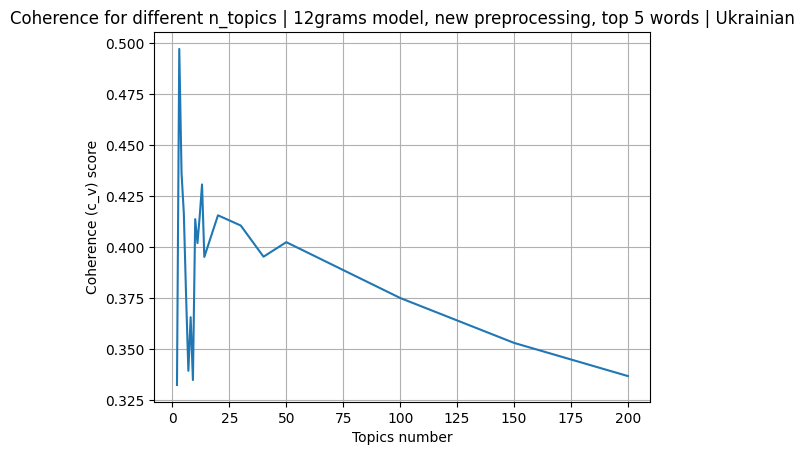

In [77]:
plt.plot(topic_numbers_12grams, coherences_12grams)
plt.title('Coherence for different n_topics | 12grams model, new preprocessing, top 5 words | Ukrainian')
plt.xlabel('Topics number')
plt.ylabel('Coherence (c_v) score')
plt.grid()
plt.show()

In [ ]:
coherences_12grams, predicted_topics_counts_12grams = calculate_coherence_for_plots(
    list(range(2,15)) + [20,30,40,50,100,150,200],
    texts_v4,
    dictionary_v4,
    LSAPipelineUkrainian_v3,
    preprocessed_documents_pos,
    n_top_words=10,
    ngram_range=(1,2),
    filter_by_pos=['NOUN','PNOUN','VERB','ADJ','ADV']
    tf_idf_max_df=0.9,
    tf_idf_min_df=4,
    coherence_type='c_v',
    processes=4,
    random_state=47,
    save_name='12grams_uk_new_pos',
    verbose=1
)

In [ ]:
def calculate_coherence_for_plots(topic_numbers: list, texts,
                                  dictionary, lsa_pipeline,
                                  preprocessed_documents_list,
                                  n_top_words,
                                  ngram_range = (1,1),
                                  filter_by_pos = [],
                                  tf_idf_max_df = 0.9,
                                  tf_idf_min_df = 4,
                                  coherence_type: str = 'c_v',
                                  processes: int = 1
                                  random_state = 0,
                                  save_name = False,
                                  verbose: int = 0):
    coherences = []
    predicted_topics_counts = []
    for topic_number in topic_numbers:
        LSAPipeline = lsa_pipeline(preprocessed_documents_list, tf_idf_max_df=tf_idf_max_df,
                                   tf_idf_min_df=tf_idf_min_df,
                                   lsa_components=topic_number, svd_n_iter=5,
                                   n_top_words=n_top_words, ngram_range=ngram_range,
                                   filter_by_pos=filter_by_pos,
                                   import_preprocessed_documents=True, random_state=random_state)
        topics = LSAPipeline.run_topics_detection()
        tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
        # Calculate the coherence score using Gensim
        coherence_model = CoherenceModel(topics=topics,
                                         texts=texts,
                                         dictionary=dictionary,
                                         coherence=coherence_type,
                                         processes=processes)
        coherence_score = coherence_model.get_coherence()
        predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
        predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
        if verbose == 1:
            print(f'--Topic number {topic_number} coherence score: {coherence_score}')
        coherences.append(coherence_score)
        predicted_topics_counts.append(predicted_topics_count)
    if save_name:
        with open('coherences_{save_name}.json','w') as json_file:
            json.dump({'coherences': coherences,
                       'predicted_topics': predicted_topics_counts}, json_file)
    return coherences, predicted_topics_counts

In [ ]:
plot_coherences(
    list(range(2,15)) + [20,30,40,50,100,150,200],
    coherences_12grams,
    '12grams model, new preprocessing, only certain PoS',
    'Ukrainian'
)

In [ ]:
def plot_coherences(topic_numbers, coherences,
                    plot_description: str = '',
                    lang_description: str = 'Ukrainian'):
    plt.plot(topic_numbers, coherences)
    plt.title(f'Coherence for different n_topics | {plot_description} | {lang_description}')
    plt.xlabel('Topics number')
    plt.ylabel('Coherence (c_v) score')
    plt.grid()
    plt.show()